# Problem 3.1

**Integrated Energy Grids**

**Problem 3.1. Joint capacity and dispatch optimisation and limiting $CO_2$ emissions**

**Optimise the capacity and dispatch of solar PV, onshore wind, and open-cycle gas turbine (OCGT) generators to supply the inelastic electricity demand throughout one year.**

**To do this, take the time series for the wind and solar capacity factors for Portugal in 2015 obtained from https://zenodo.org/record/3253876#.XSiVOEdS8l0 and https://zenodo.org/record/2613651#.X0kbhDVS-uV (select the file ‘pvoptimal.csv’) and the electricity demand from https://github.com/aleks-g/integrated-energy-grids/tree/main/integrated-energy-grids/Problems/data.**

**Consider the annualised capital costs and marginal generation costs for the different technologies in Table 1. The efficiency for the OCGT plant is 0.41..**

**a) Calculate the total system cost, the optimal installed capacities, the annual generation per technology, and plot the hourly generation and demand during January.**

**b) Calculate the revenues collected by every technology throughout the year and show that their sum is equal to their costs.**

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `numpy` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

:::{note}
See also https://model.energy.
:::

In this exercise, we want to build a replica of [model.energy](https://model.energy). This tool calculates the cost of meeting a constant electricity demand from a combination of wind power, solar power and storage for different regions of the world. We deviate from [model.energy](https://model.energy) by including electricity demand profiles rather than a constant electricity demand. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

Set parameter Username
Set parameter LicenseID to value 2767832
Academic license - for non-commercial use only - expires 2027-01-20


## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]


Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [6]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [7]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [8]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

We can now read the capital and marginal cost of onshore wind, solar and OCGT

In [9]:
costs.at["onwind", "capital_cost"] #EUR/MW/a

np.float64(101644.12332388277)

In [10]:
costs.at["solar", "capital_cost"] #EUR/MW/a

np.float64(51346.82981964593)

In [11]:
costs.at["OCGT", "capital_cost"] #EUR/MW/a

np.float64(47718.67056370105)

In [12]:
costs.at["OCGT", "marginal_cost"] #EUR/MWh

np.float64(64.6839512195122)

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [13]:
data_solar = pd.read_csv('data/pv_optimal.csv',sep=';')
data_solar.index = pd.DatetimeIndex(data_solar['utc_time'])

data_wind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';')
data_wind.index = pd.DatetimeIndex(data_wind['utc_time'])

data_el = pd.read_csv('data/electricity_demand.csv',sep=';')
data_el.index = pd.DatetimeIndex(data_el['utc_time'])

The data format can now be analyzed using the .head() function to show the first lines of the data set

In [14]:
data_solar.head()

,utc_time,AUT,BEL,BGR,BIH,CHE,CYP,CZE,DEU,DNK,...,MLT,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
utc_time,,,,,,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,1979-01-01T00:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 01:00:00+00:00,1979-01-01T01:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 02:00:00+00:00,1979-01-01T02:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 03:00:00+00:00,1979-01-01T03:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 04:00:00+00:00,1979-01-01T04:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use timeseries for Portugal in this excercise

In [15]:
country = 'PRT'

### Joint capacity and dispatch optimization

For building the model, we start again by initialising an empty network, adding the snapshots, and the electricity bus.

In [16]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

n.add("Bus",
            "electricity")

n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

We add all the technologies we are going to include as carriers. Defining carriers is not mandatory but will ease plotting and assigning emissions of CO2 in future steps. 

In [17]:
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "CCGT",
    "battery storage",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred","yellow-green", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Next, we add the demand time series to the model.

In [18]:
# add load to the bus
n.add("Load",
      "demand",
      bus="electricity",
      p_set=data_el[country].values)

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

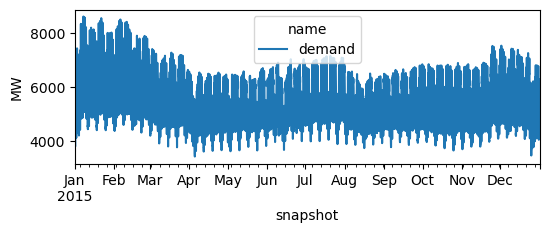

In [19]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We now add the generators and set up their capacities to be extendable so that they can be optimized together with the dispatch time series. For the wind and solar generator, we need to indicate the capacity factor or maximum power per unit 'p_max_pu'

In [20]:
n.add(
    "Generator",
    "OCGT",
    bus="electricity",
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)

CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "onwind",
        bus="electricity",
        carrier="onwind",
        p_max_pu=CF_wind.values,
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "solar",
        bus="electricity",
        carrier="solar",
        p_max_pu= CF_solar.values,
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

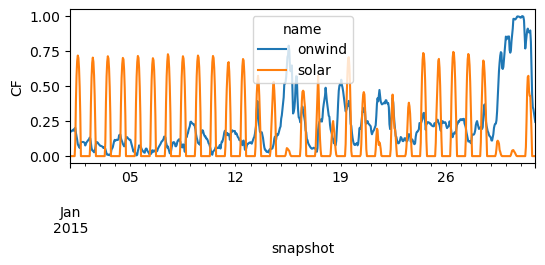

In [21]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

### Model Run

We can already solved the model using the open-solver "highs" or the commercial solver "gurobi" with the academic license

In [22]:
n.optimize(solver_name="highs")

Index(['electricity'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 458.92it/s]
INFO:linopy.io: Writing time: 0.1s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-xq8hn9zo has 61323 rows; 26283 cols; 100761 nonzeros
Coefficient ranges:
  Matrix  [1e-03, 1e+00]
  Cost    [1e-02, 1e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e+03, 9e+03]
Presolving model
26316 rows, 17559 cols, 57030 nonzeros  0s
Dependent equations search running on 4398 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
26316 rows, 17559 cols, 57030 nonzeros  0s
Presolve reductions: rows 26316(-35007); columns 17559(-8724); nonzeros 57030(-43731) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61323 duals
Objective: 3.11e+09
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


      17574     3.1120276519e+09 Pr: 0(0) 1s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-xq8hn9zo
Model status        : Optimal
Simplex   iterations: 17574
Objective value     :  3.1120276519e+09
P-D objective error :  9.7297205963e-15
HiGHS run time      :          0.89


('ok', 'optimal')

Now, we can look at the results and evaluate the total system cost (in billion Euros per year)

In [23]:
n.objective / 1e9

3.112027651898134

The optimised capacities in GW:

In [24]:
n.generators.p_nom_opt.div(1e3)  # MW -> GW

name
OCGT      8.193448
onwind    5.241379
solar     8.371349
Name: p_nom_opt, dtype: float64

The total energy generation by technology in TWh:

In [25]:
n.generators_t.p.sum().div(1e6)  # MWh -> TWh

name
OCGT      26.974833
onwind     9.434456
solar     12.520371
dtype: float64

We can plot the dispatch of every generator thoughout January

<Axes: xlabel='snapshot', ylabel='dispatch'>

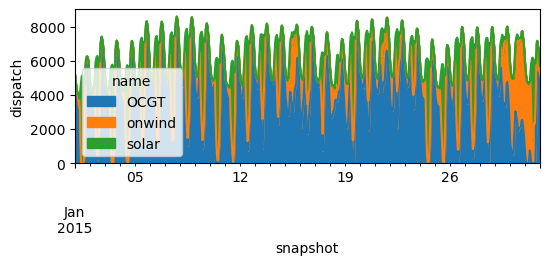

In [26]:
n.generators_t.p.loc["2015-01"].plot.area(figsize=(6, 2), ylabel="dispatch")

<Axes: xlabel='snapshot', ylabel='demand'>

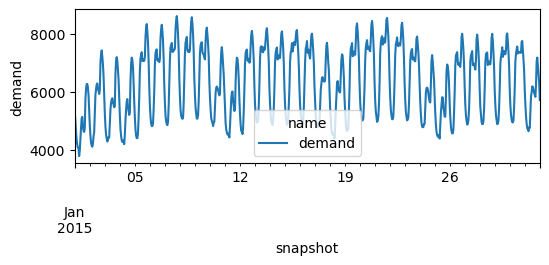

In [27]:
n.loads_t.p.loc["2015-01"].plot(figsize=(6, 2), ylabel="demand")

**b) Calculate the revenues collected by every technology throughout the year and show that their sum is equal to their costs.**

To calculate the revenues collected by every technology, we multiply the energy generated in every hour by the electricity price in that hour and sum for the entire year.

In [28]:
n.generators_t.p.multiply(n.buses_t.marginal_price.to_numpy()).sum().div(1e6) # EUR -> MEUR

name
OCGT      2135.819257
onwind     546.233469
solar      429.974926
dtype: float64

This corresponds to the total cost for every technology, which we can also read using the statistics module:

In [29]:
(n.statistics.capex() + n.statistics.opex()).div(1e6)

component  carrier
Generator  OCGT       2135.819257
           onwind      546.233469
           solar       429.974926
dtype: float64

**Now we are adding the possibility of installing battery storage. The annualised capital cost of the battery comprises 12,894 EUR/MWh/a for the energy capacity and 24,678 EUR/MW/a for the inverter. The inverter efficiency is 0.96 and the battery is assumed to have a fixed energy-to-power ratio of 2 hours. Assume also an existing combined-cycle gas turbine (CCGT) unit with an electricity generation capacity of 6 GW and efficiency of 0.58. The annualised capital cost and marginal generation costs for the CCGT are respectively 104,788 EUR/MW/a and 46.8 EUR/MWh.**

**c) Calculate the total system cost, the optimal installed capacities, the annual generation per technology, and plot the hourly generation and demand during January.**

Let's build the model from scratch to include the battery storage and the CCGT generator.

In [30]:
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

In [31]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

n.add("Bus",
            "electricity")

n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

We add all the technologies we are going to include as carriers. Defining carriers is not mandatory but will ease plotting and assigning emissions of CO2 in future steps. 

In [32]:
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "CCGT",
    "battery storage",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred","yellow-green", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Next, we add the demand time series to the model.

In [33]:
# add load to the bus
n.add("Load",
      "demand",
      bus="electricity",
      p_set=data_el[country].values)

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

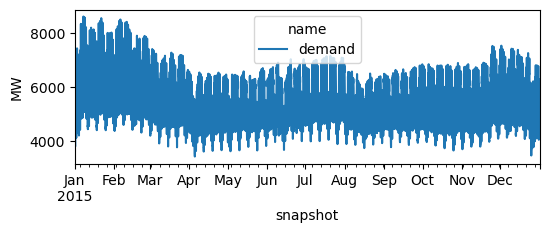

In [34]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We add now the generators and set up their capacities to be extendable so that they can be optimized together with the dispatch time series. For the wind and solar generator, we need to indicate the capacity factor or maximum power per unit 'p_max_pu'

In [35]:
n.add(
    "Generator",
    "OCGT",
    bus="electricity",
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)

CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "onwind",
        bus="electricity",
        carrier="onwind",
        p_max_pu=CF_wind.values,
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "solar",
        bus="electricity",
        carrier="solar",
        p_max_pu= CF_solar.values,
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

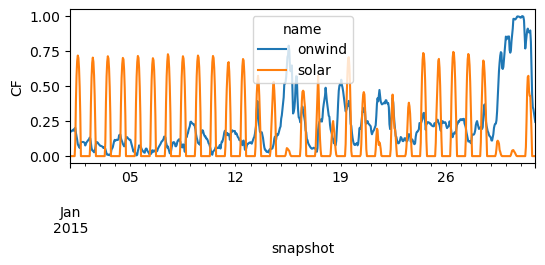

In [36]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

We add the battery storage, assuming a fixed energy-to-power ratio of 2 hours, i.e. if fully charged, the battery can discharge at full capacity for 2 hours. 

For the capital cost, we have to factor in both the capacity and energy cost of the storage. 

We include the charging and discharging efficiencies we enforce a cyclic state-of-charge condition, i.e. the state of charge at the beginning of the optimisation period must equal the final state of charge.

In [37]:
n.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

We add the Combined Cycle Gas Turbine (CCGT). In this case, its capacity is not extendable but fixed to 1 GW. 

In [38]:
n.add(
    "Generator",
    "CCGT",
    bus="electricity",
    carrier="CCGT",
    capital_cost=costs.at["CCGT", "capital_cost"],
    marginal_cost=costs.at["CCGT", "marginal_cost"],
    efficiency=costs.at["CCGT", "efficiency"],
    p_nom=6000, #6 Gw
)

### Model Run

We can already solved the model using the open-solver "highs" or the commercial solver "gurobi" with the academic license

In [39]:
n.optimize(solver_name="highs")

Index(['electricity'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 563.97it/s]
INFO:linopy.io: Writing time: 0.14s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-n9qqcql3 has 140164 rows; 61324 cols; 258442 nonzeros
Coefficient ranges:
  Matrix  [1e-03, 2e+00]
  Cost    [1e-02, 1e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e+03, 9e+03]
Presolving model
65718 rows, 56962 cols, 179634 nonzeros  0s
Dependent equations search running on 17520 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
65718 rows, 56962 cols, 179634 nonzeros  0s
Presolve reductions: rows 65718(-74446); columns 56962(-4362); nonzeros 179634(-78808) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.89297e+07) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61324 primals, 140164 duals
Objective: 4.51e+08
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


      47118     4.5050855238e+08 Pr: 0(0); Du: 0(2.9754e-13) 2s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-n9qqcql3
Model status        : Optimal
Simplex   iterations: 47118
Objective value     :  4.5050855238e+08
P-D objective error :  8.0706199872e-14
HiGHS run time      :          2.02


('ok', 'optimal')

Now, we can look at the results and evaluate the total system cost (in billion Euros per year)

In [40]:
n.objective / 1e9

0.4505085523848367

The optimised capacities in GW:

In [41]:
n.generators.p_nom_opt.div(1e3)  # MW -> GW

name
OCGT      2.172000
onwind   -0.000000
solar     0.238397
CCGT      6.000000
Name: p_nom_opt, dtype: float64

The optimised battery capacity can be calcualted as 

In [42]:
n.storage_units.p_nom_opt.div(1e3)  # MW -> GW

name
battery storage    0.491146
Name: p_nom_opt, dtype: float64

The total energy generation by technology in TWh:

In [43]:
n.generators_t.p.sum().div(1e6)  # MWh -> TWh

name
OCGT       1.556202
onwind     0.000000
solar      0.359807
CCGT      47.035541
dtype: float64

We can plot the dispatch of every generator thoughout January

<Axes: xlabel='snapshot', ylabel='dispatch'>

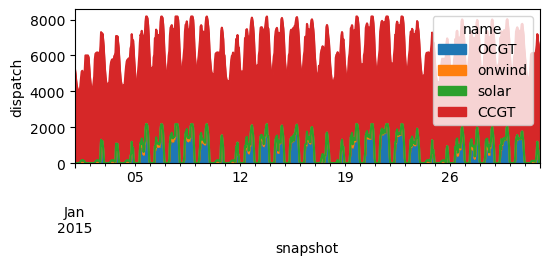

In [44]:
n.generators_t.p.loc["2015-01"].plot.area(figsize=(6, 2), ylabel="dispatch")

We can also plot the charging and discharging of the battery

<Axes: xlabel='snapshot', ylabel='battery'>

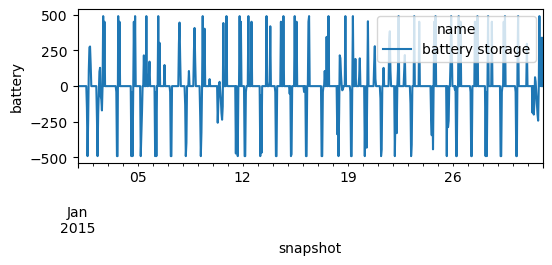

In [45]:
n.storage_units_t.p.loc["2015-01"].plot(figsize=(6, 2), ylabel="battery")

and the demand time series

<Axes: xlabel='snapshot', ylabel='demand'>

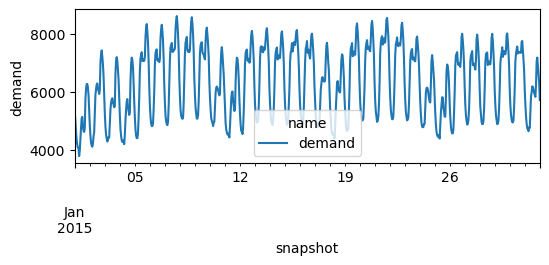

In [46]:
n.loads_t.p.loc["2015-01"].plot(figsize=(6, 2), ylabel="demand")

**d) How does the CCGT power plant recover its cost?**

To calculate the revenues collected by every technology, for every generator, we multiply the energy generated in very hour by the electricity price in that hour and sum for the entire year.

In [47]:
n.generators_t.p.multiply(n.buses_t.marginal_price.to_numpy()).sum().div(1e6) # EUR -> MEUR

name
OCGT       204.306271
onwind       0.000000
solar       12.244765
CCGT      1552.276695
dtype: float64

This corresponds to the total cost for every technology, which we can also read using the statistics module:

In [48]:
(n.statistics.capex() + n.statistics.opex()).div(1e6)

component    carrier        
Generator    CCGT               837.777588
             OCGT               204.306271
             solar               12.244765
StorageUnit  battery storage           NaN
dtype: float64

The CCGT does not recover its full cost. This is to be expected because its capacity was not optimized but set exogenously 

**e) How does the battery recover its cost?**

The battery capacity is also co-optimized with the dispatch, so it exactly recovers its cost by buying electricity when the price is low and selling when it is high. The revenues from market can be calculated by multiplying the battery charging and discharging by the electricity price time series

In [49]:
n.storage_units_t.p.multiply(n.buses_t.marginal_price.to_numpy()).sum().div(1e6) # EUR -> MEUR

name
battery storage    24.908054
dtype: float64

The market revenues exactly correspons with the total battery costs

In [50]:
n.storage_units.p_nom_opt*(costs.at["battery inverter", "capital_cost"]+ 2 * costs.at["battery storage", "capital_cost"])/(1e6)# EUR -> MEUR

name
battery storage    24.908054
Name: p_nom_opt, dtype: float64

**Now assume that methane gas emits 0.198 tCO2 per MWh of thermal energy contained in the gas. The OCGT unit has an efficiency of 0.41. Limit the maximum CO$_2$ emissions to 5 MtCO2/year.**

**f) Calculate the optimal installed capacities and plot the hourly generation and demand during January.**

Since we already included the CO2 emissions in the carrier definitions, we add the global constraint (a global CO2 emission limit) to the problem.

Let's build the model from scratch to prevent any overwriting.

In [51]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

n.add("Bus",
            "electricity")

n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

We add all the technologies we are going to include as carriers. Defining carriers is not mandatory but will ease plotting and assigning emissions of CO2 in future steps. 

In [52]:
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "CCGT",
    "battery storage",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred","yellow-green", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Next, we add the demand time series to the model.

In [53]:
# add load to the bus
n.add("Load",
      "demand",
      bus="electricity",
      p_set=data_el[country].values)

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

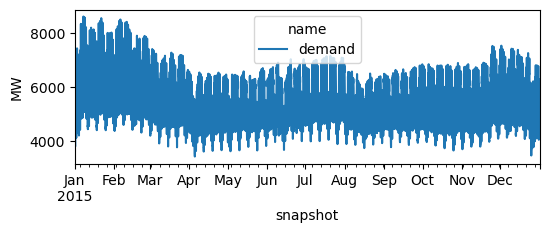

In [54]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We add now the generators and set up their capacities to be extendable so that they can be optimized together with the dispatch time series. For the wind and solar generator, we need to indicate the capacity factor or maximum power per unit 'p_max_pu'

In [55]:
n.add(
    "Generator",
    "OCGT",
    bus="electricity",
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)

CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "onwind",
        bus="electricity",
        carrier="onwind",
        p_max_pu=CF_wind.values,
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "solar",
        bus="electricity",
        carrier="solar",
        p_max_pu= CF_solar.values,
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

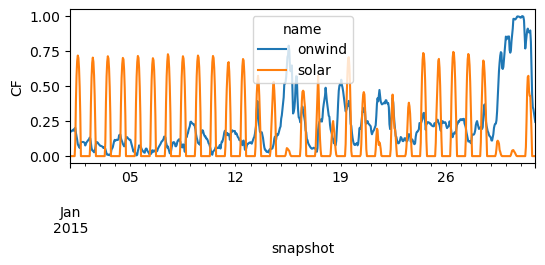

In [56]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

We add the battery storage, assuming a fixed energy-to-power ratio of 2 hours, i.e. if fully charged, the battery can discharge at full capacity for 2 hours. 

For the capital cost, we have to factor in both the capacity and energy cost of the storage. 

We include the charging and discharging efficiencies we enforce a cyclic state-of-charge condition, i.e. the state of charge at the beginning of the optimisation period must equal the final state of charge.

In [57]:
n.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

We add the Combined Cycle Gas Turbine (CCGT). In this case, its capacity is not extendable but fixed to 1 GW. 

In [58]:
n.add(
    "Generator",
    "CCGT",
    bus="electricity",
    carrier="CCGT",
    capital_cost=costs.at["CCGT", "capital_cost"],
    marginal_cost=costs.at["CCGT", "marginal_cost"],
    efficiency=costs.at["CCGT", "efficiency"],
    p_nom=6000, #6 Gw
)

In [59]:
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=5000000, #5MtCO2
)

We can already solved the model using the open-solver "highs" or the commercial solver "gurobi" with the academic license

In [60]:
n.optimize(solver_name="highs")

Index(['electricity'], dtype='object', name='name')


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 608.83it/s]
INFO:linopy.io: Writing time: 0.17s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-tmmicsm9 has 140165 rows; 61324 cols; 275962 nonzeros
Coefficient ranges:
  Matrix  [1e-03, 2e+00]
  Cost    [1e-02, 1e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e+03, 5e+06]
Presolving model
65719 rows, 56962 cols, 197154 nonzeros  0s
Dependent equations search running on 17520 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
65719 rows, 56962 cols, 197154 nonzeros  0s
Presolve reductions: rows 65719(-74446); columns 56962(-4362); nonzeros 197154(-78808) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.89297e+07) 0s
      28579     1.1213648015e+09 Pr: 32456(1.62529e+08); Du: 0(9.80681e-08) 5s
      33911     1.7132722799e+09 Pr: 12846(8.22872e+09); Du: 0(2.7654e-07) 10s
      38314     2.00309

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61324 primals, 140165 duals
Objective: 2.14e+09
Solver model: available
Solver message: Optimal



      45362     2.1407922871e+09 Pr: 0(0); Du: 0(8.75202e-12) 23s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-tmmicsm9
Model status        : Optimal
Simplex   iterations: 45362
Objective value     :  2.1407922871e+09
P-D objective error :  3.6751875256e-15
HiGHS run time      :         22.67


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

Now, we can look at the results and evaluate the total system cost (in billion Euros per year)

In [61]:
n.objective / 1e9

2.1407922871056906

The optimised capacities in GW:

In [62]:
n.generators.p_nom_opt.div(1e3)  # MW -> GW

name
OCGT      -0.000000
onwind    12.548370
solar     10.281573
CCGT       6.000000
Name: p_nom_opt, dtype: float64

The optimised battery capacity can be calculated as 

In [63]:
n.storage_units.p_nom_opt.div(1e3)  # MW -> GW

name
battery storage    4.830266
Name: p_nom_opt, dtype: float64

The total energy generation by technology in TWh:

In [64]:
n.generators_t.p.sum().div(1e6)  # MWh -> TWh

name
OCGT       0.000000
onwind    19.021846
solar     15.491719
CCGT      14.646465
dtype: float64

We can plot the dispatch of every generator thoughout January

<Axes: xlabel='snapshot', ylabel='dispatch'>

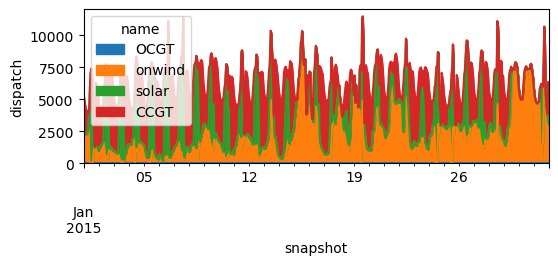

In [65]:
n.generators_t.p.loc["2015-01"].plot.area(figsize=(6, 2), ylabel="dispatch")

We can also plot the charging and discharging of the battery

<Axes: xlabel='snapshot', ylabel='battery'>

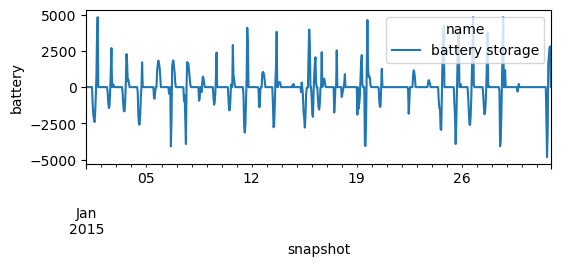

In [66]:
n.storage_units_t.p.loc["2015-01"].plot(figsize=(6, 2), ylabel="battery")